In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import joblib

import mlflow
from mlflow.models.signature import infer_signature

## Set up the local tracking server

In [112]:
mlflow.set_tracking_uri("http://localhost:5000")

In [89]:
# Create a new MLflow Experiment
EXPERIMENT_NAME = "ML Assignment 1 Experiment"
mlflow.set_experiment(EXPERIMENT_NAME)

2026/02/02 18:09:27 INFO mlflow.tracking.fluent: Experiment with name 'ML Assignment 1 Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/517596058623030614', creation_time=1770026967506, experiment_id='517596058623030614', last_update_time=1770026967506, lifecycle_stage='active', name='ML Assignment 1 Experiment', tags={}>

## Data Exploration

In [4]:
# Load the 2011 dataset
data_2011 = pd.read_csv('./Dataset/day_2011.csv')

In [5]:
# View the number of rows and columns of the dataset
data_2011.shape

(365, 12)

In [6]:
# Preview of the the first 5 rows of the dataset
data_2011.head()

,dteday,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01/01/2011,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,02/01/2011,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,03/01/2011,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,04/01/2011,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,05/01/2011,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [7]:
# View column datatypes and non-null counts
data_2011.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      365 non-null    object 
 1   season      365 non-null    int64  
 2   mnth        365 non-null    int64  
 3   holiday     365 non-null    int64  
 4   weekday     365 non-null    int64  
 5   workingday  365 non-null    int64  
 6   weathersit  365 non-null    int64  
 7   temp        365 non-null    float64
 8   atemp       365 non-null    float64
 9   hum         365 non-null    float64
 10  windspeed   365 non-null    float64
 11  cnt         365 non-null    int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 34.3+ KB


In [8]:
# Convert datatype of dteday column to datetime for extraction of time columns
data_2011['dteday'] = pd.to_datetime(data_2011['dteday'], format='%d/%m/%Y')


In [9]:
# Check that datatype of dteday has been changed to datetime
data_2011['dteday'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 365 entries, 0 to 364
Series name: dteday
Non-Null Count  Dtype         
--------------  -----         
365 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.0 KB


array([[<Axes: title={'center': 'dteday'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'mnth'}>],
       [<Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'weekday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'weathersit'}>,
        <Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>],
       [<Axes: title={'center': 'hum'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'cnt'}>]], dtype=object)

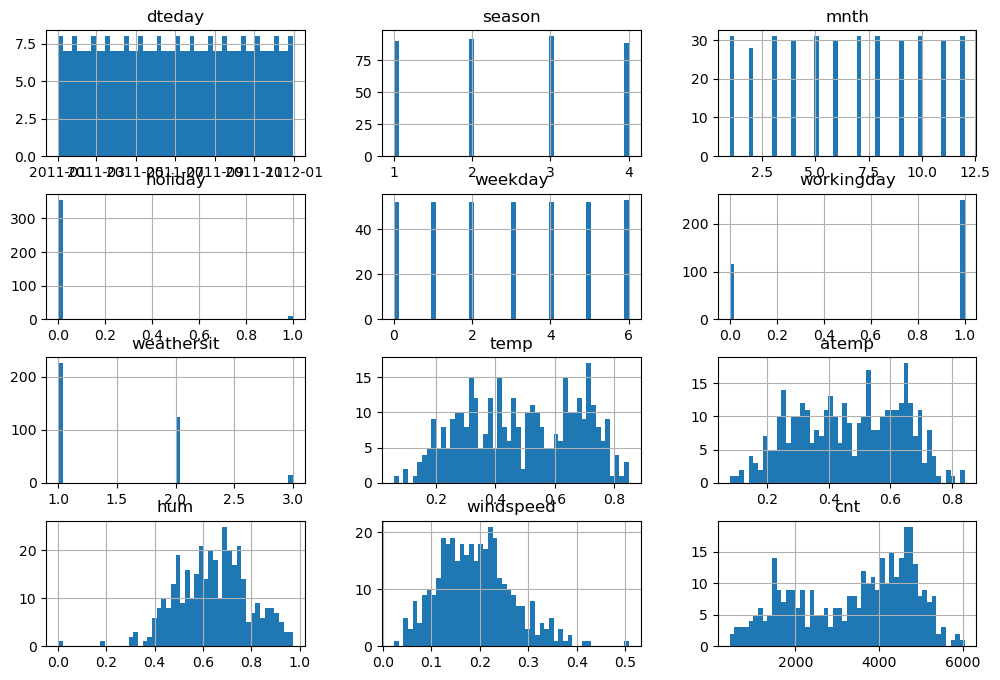

In [10]:
# View distribution of the dataset (check for outliers)
data_2011.hist(
    column=data_2011.columns,
    bins=50,
    figsize=(12, 8)
)

In [113]:
# Check that there are no null values
data_2011.isnull().sum()

season        0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
day           0
dtype: int64

## Data Preprocessing

In [12]:
# Extract day from dteday and drop dteday column as month is already present and year is consistent for entire dataset
data_2011['day'] = data_2011['dteday'].dt.day
data_2011 = data_2011.drop(columns=['dteday'])

In [13]:
# Perform train-test split
# Only 365 rows, so use 80-20 split row more training data
x_train, x_test, y_train, y_test = train_test_split(
    data_2011.drop(columns=['cnt']),
    data_2011['cnt'],
    test_size=0.2, random_state=611
)

In [14]:
winsor = Winsorizer(
    capping_method='quantiles',  # use percentile-based capping
    tail='both',                 # cap both tails
    fold=0.01,                   # 1% on left, 91% on right
    variables=['hum','windspeed'],  # columns with some outliers
)

# Fit on train and transform it
winsor.fit(x_train)
x_train_win = winsor.transform(x_train)


In [17]:
# Create one hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop=None)

# Fit encoder and transform training data
x_train_enc = ohe.fit_transform(x_train_win[["mnth", "season", "weekday", "weathersit","day"]])
# Make numpy array back into dataframe
x_train_enc = pd.DataFrame(
    x_train_enc, 
    columns=ohe.get_feature_names_out(["mnth", "season", "weekday", "weathersit","day"]), # Non-encoded columns not included 
    index=x_train_win.index # Match index with pre-encoded data
)
# Concatenate the non-encoded columns using index
x_train_enc = pd.concat([x_train_win[["holiday","workingday","temp","atemp","hum","windspeed"]], x_train_enc], axis=1)

# Transform test data
x_test_enc = ohe.transform(x_test[["mnth", "season", "weekday", "weathersit","day"]])
x_test_enc = pd.DataFrame(
    x_test_enc, 
    columns=ohe.get_feature_names_out(["mnth", "season", "weekday", "weathersit","day"]), # Non-encoded columns not included 
    index=x_test.index # Match index with pre-encoded data
)
# Concatenate the non-encoded columns using index
x_test_enc = pd.concat([x_test[["holiday","workingday","temp","atemp","hum","windspeed"]], x_test_enc], axis=1)


In [18]:
# View number of rows and columns after encoding
x_train_enc.shape

(292, 63)

## Model Training

In [19]:
# Create baseline Linear Regression model
lr_model = LinearRegression()
# Fit the model on non-encoded training data
lr_model.fit(x_train_win, y_train)
# Creating predictions using non-encoded test data
test_pred = lr_model.predict(x_test)

In [20]:
# Show the metrics r2, mae, rmse 
print("Test R2 value before encoding:", r2_score(y_test, test_pred))
print("Test MAE value before encoding:", mean_absolute_error(y_test, test_pred))
print("Test RMSE value before encoding:", np.sqrt(mean_squared_error(y_test, test_pred)))

Train R2 value before encoding: 0.7429546030263913
Test MAE value before encoding: 583.274093250835
Test RMSE value before encoding: 752.0014896828397


In [21]:
# Fit the model on encoded training data
lr_model.fit(x_train_enc, y_train)
# Creating predictions using encoded test data
test_pred = lr_model.predict(x_test_enc)

In [22]:
# Show the metrics r2, mae, rmse 
print("Test R2 value after encoding:", r2_score(y_test, test_pred))
print("Test MAE value after encoding:", mean_absolute_error(y_test, test_pred))
print("Test RMSE value after encoding:", np.sqrt(mean_squared_error(y_test, test_pred)))

Train R2 value after encoding: 0.7937413883339239
Test MAE value after encoding: 504.05479452054794
Test RMSE value after encoding: 673.6275341719046


##### Comparison is to ensure encoding had positive effect on model rather than negative

#### RMSE/MAE ≈ 1.34. Most errors are around moderate, but there are some larger deviations that push RMSE up

## Log baseline run in MLflow

In [90]:
BASELINE_RUN_ID = None
with mlflow.start_run(run_name="baseline_model") as run:
    BASELINE_RUN_ID = run.info.run_id
    
    # Set tags which can be searched for in Mlflow
    mlflow.set_tag("role", "baseline")
    mlflow.set_tag("dataset", "Bike Sharing Demand 2011")
    mlflow.set_tag("problem_type", "regression")
    
    # Model hyperparameters (log_param)
    model = LinearRegression()
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("feature_count", 63)

    # Train
    model.fit(x_train_enc, y_train)

    # Evaluate
    pred = model.predict(x_test_enc)
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))


    # Log metrics (log_metric)
    mlflow.log_metric("baseline_r2", float(r2))
    mlflow.log_metric("baseline_mae", float(mae))
    mlflow.log_metric("baseline_rmse", float(rmse))

    #Log the baseline model to MLFlow
    sig = infer_signature(x_train_enc,pred)
    mlflow.sklearn.log_model(model, name="bike_demand_baseline_model",
                             input_example=x_test_enc.iloc[:5],
                             signature=sig)

print("Baseline Run ID:", BASELINE_RUN_ID)

C:\Users\Admin\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run baseline_model at: http://localhost:5000/#/experiments/517596058623030614/runs/ef57bb7582454bd2be5caac369cfd2ef
🧪 View experiment at: http://localhost:5000/#/experiments/517596058623030614
Baseline Run ID: ef57bb7582454bd2be5caac369cfd2ef


## Log improved model run in MLflow

In [91]:
BASELINE_RUN_ID = None
with mlflow.start_run(run_name="random_forest_model") as run:
    BASELINE_RUN_ID = run.info.run_id
    
    # Set tags which can be searched for in Mlflow
    mlflow.set_tag("role", "improved model")
    mlflow.set_tag("dataset", "Bike Sharing Demand 2011")
    mlflow.set_tag("problem_type", "regression")
    
    # Model hyperparameters (log_param)
    model = RandomForestRegressor(max_depth=5, n_estimators=200, random_state=611)
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("feature_count", 63)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("random_state", 611)

    # Train
    model.fit(x_train_enc, y_train)

    # Evaluate
    pred = model.predict(x_test_enc)
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))


    # Log metrics (log_metric)
    mlflow.log_metric("test_r2", float(r2))
    mlflow.log_metric("test_mae", float(mae))
    mlflow.log_metric("test_rmse", float(rmse))

    #Log the improved model to MLFlow
    sig = infer_signature(x_train_enc,pred)
    mlflow.sklearn.log_model(model, name="random_forest",
                             input_example=x_test_enc.iloc[:5],
                             signature=sig, registered_model_name="bike_demand_random_forest") # Register the model

print("Baseline Run ID:", BASELINE_RUN_ID)

C:\Users\Admin\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'bike_demand_random_forest'.
2026/02/02 18:11:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: bike_demand_random_forest, version 1
Created version '1' of model 'bike_demand_random_forest'.


🏃 View run random_forest_model at: http://localhost:5000/#/experiments/517596058623030614/runs/e78bf0eba5094bb6a5f52ead46ef29fb
🧪 View experiment at: http://localhost:5000/#/experiments/517596058623030614
Baseline Run ID: e78bf0eba5094bb6a5f52ead46ef29fb


In [94]:
rf = RandomForestRegressor()

In [96]:
# Use GridSearch to help optimize paramters for random forest model
param_grid = {
    "criterion": ["squared_error", "absolute_error"],
    'n_estimators': [100, 200, 300],           # number of trees
    'max_depth': [5,7,8,10],           # maximum depth of trees
    'min_samples_split': [2, 5, 10],          # minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],            # minimum samples in a leaf
}
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='r2',  # to minimize r2
    n_jobs=-1,              # use all cores
)
grid_search.fit(x_train_enc, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [5, 7, 8, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [115]:
# Show best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [117]:
# Create random forest model with optimized parameters
rf = RandomForestRegressor(max_depth=9, n_estimators=150, criterion='absolute_error', min_samples_leaf=1, min_samples_split=2,random_state=611)
rf.fit(x_train_enc,y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=9, n_estimators=150,
                      random_state=611)

In [118]:
# Evaluate the optimized random forest model
test_pred = rf.predict(x_test_enc)
print("Test R2 value after encoding:", r2_score(y_test, test_pred))
print("Test MAE value after encoding:", mean_absolute_error(y_test, test_pred))
print("Test RMSE value after encoding:", np.sqrt(mean_squared_error(y_test, test_pred)))

Test R2 value after encoding: 0.8728340549336253
Test MAE value after encoding: 406.8642922374429
Test RMSE value after encoding: 528.9312139685063


## Log improved random forest model run in MLflow

In [97]:
BASELINE_RUN_ID = None
with mlflow.start_run(run_name="improved_random_forest_model") as run:
    BASELINE_RUN_ID = run.info.run_id
    
    # Set tags which can be searched for in Mlflow
    mlflow.set_tag("role", "improved model")
    mlflow.set_tag("dataset", "Bike Sharing Demand 2011")
    mlflow.set_tag("problem_type", "regression")
    
    # Model hyperparameters (log_param)
    model = RandomForestRegressor(max_depth=9, n_estimators=150, criterion='absolute_error', min_samples_leaf=1, min_samples_split=2,random_state=611)
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("feature_count", 63)
    mlflow.log_param("max_depth", 9)
    mlflow.log_param("n_estimators", 150)
    mlflow.log_param("criterion", 'absolute_error')
    mlflow.log_param("min_samples_leaf", 1)
    mlflow.log_param("min_samples_split", 2)
    mlflow.log_param("random_state", 611)

    # Train
    model.fit(x_train_enc, y_train)

    # Evaluate
    pred = model.predict(x_test_enc)
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))


    # Log metrics (log_metric)
    mlflow.log_metric("test_r2", float(r2))
    mlflow.log_metric("test_mae", float(mae))
    mlflow.log_metric("test_rmse", float(rmse))

    #Log the optimized model to MLFlow
    sig = infer_signature(x_train_enc,pred)
    mlflow.sklearn.log_model(model, name="random_forest",
                             input_example=x_test_enc.iloc[:5],
                             signature=sig, registered_model_name="bike_demand_random_forest") # Version 2 of registered model

print("Baseline Run ID:", BASELINE_RUN_ID)

C:\Users\Admin\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Registered model 'bike_demand_random_forest' already exists. Creating a new version of this model...
2026/02/02 18:22:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: bike_demand_random_forest, version 2
Created version '2' of model 'bike_demand_random_forest'.


🏃 View run improved_random_forest_model at: http://localhost:5000/#/experiments/517596058623030614/runs/295f9f91e61344daaca18663d5f7a732
🧪 View experiment at: http://localhost:5000/#/experiments/517596058623030614
Baseline Run ID: 295f9f91e61344daaca18663d5f7a732


#### The most suitable model is the improved random forest model

It has the best performance metrics.  
Although it is more complex than the linear regression model, the significant increase in performance justifies the increased complexity. The increased model complexity also does not cause a noticeable increase in inference time, making it suitable for practical use.  
It also is more robust to changing data. As an ensemble method, it aggregates predictions from multiple decision trees, reducing sensitivity to noise and outliers. The model can also capture non-linear relationships, thus it can adapt to shifts in data distributions better compared to linear regression.


In [162]:
# Export the MLflow-registered model
joblib.dump(rf, "model.pkl")

['model.pkl']

## Data Drift Analysis

In [98]:
# Load the 2012 dataset
data_2012 = pd.read_csv('./Dataset/day_2012.csv')

array([[<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'mnth'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'weekday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weathersit'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'hum'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'cnt'}>, <Axes: title={'center': 'day'}>]],
      dtype=object)

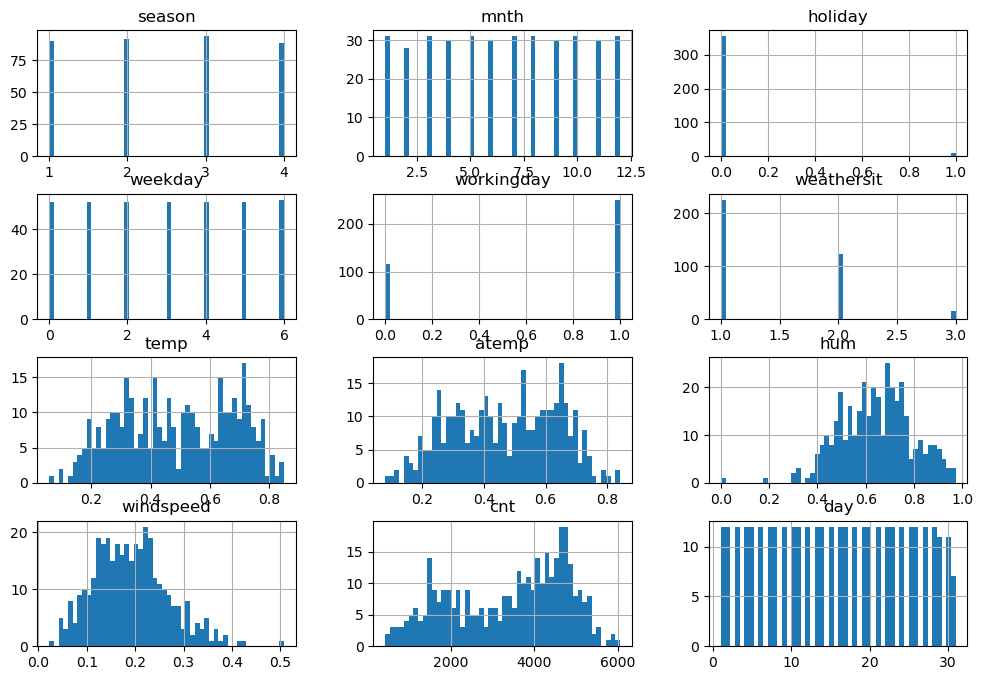

In [99]:
# Plot histograms for all columns in 2011
data_2011.hist(
    column=data_2011.columns,
    bins=50,
    figsize=(12, 8)
)

In [105]:
# Change dteday datatype to datetime
data_2012['dteday'] = pd.to_datetime(data_2012['dteday'], format='%d/%m/%Y')

array([[<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'mnth'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'weekday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weathersit'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'hum'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'cnt'}>, <Axes: title={'center': 'day'}>]],
      dtype=object)

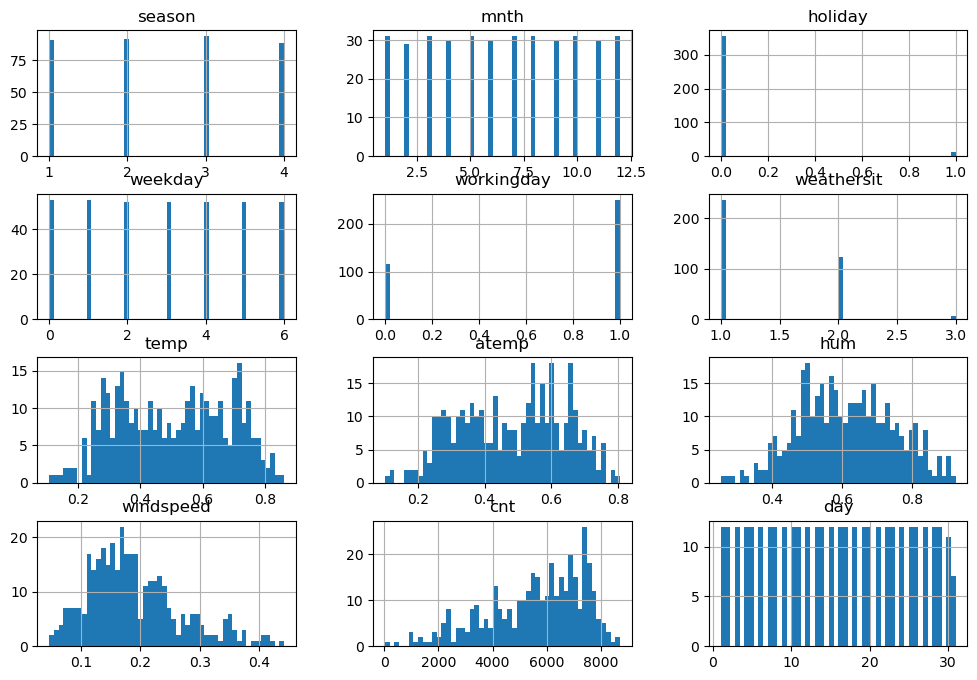

In [106]:
# Create day column for 2012 dataset and drop dteday column
data_2012['day'] = data_2012['dteday'].dt.day
data_2012 = data_2012.drop(columns=['dteday'])
# Plot histograms for all columns in 2012
data_2012.hist(
    column=data_2012.columns,
    bins=50,
    figsize=(12, 8)
)

#### Large shift in data distribution for cnt column (Target). Values are generally greater.
#### Small shift in data distribution across other columns, such as hum and windspeed.

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


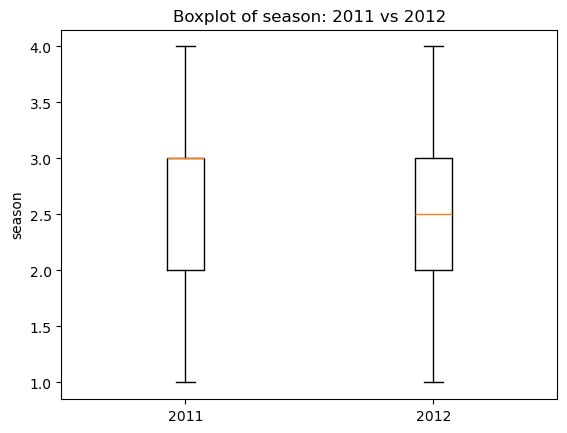

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


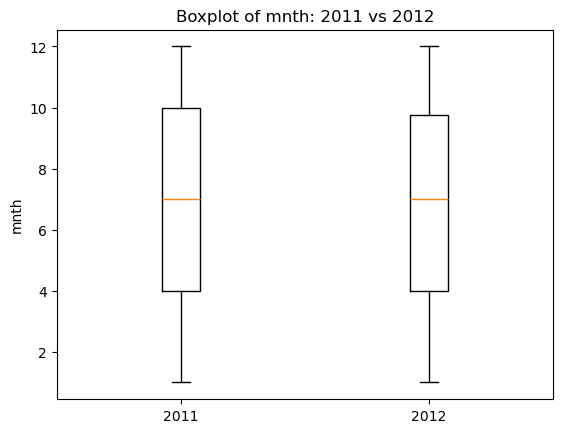

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


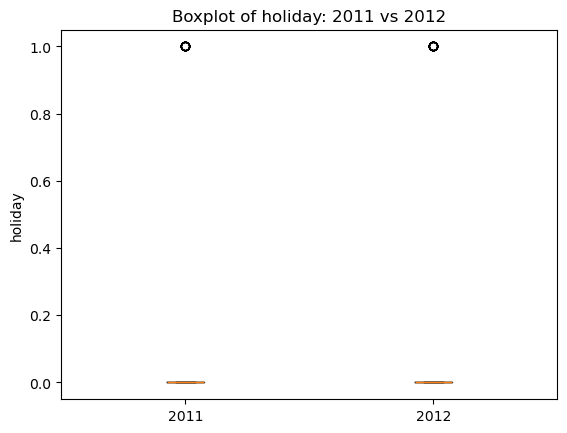

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


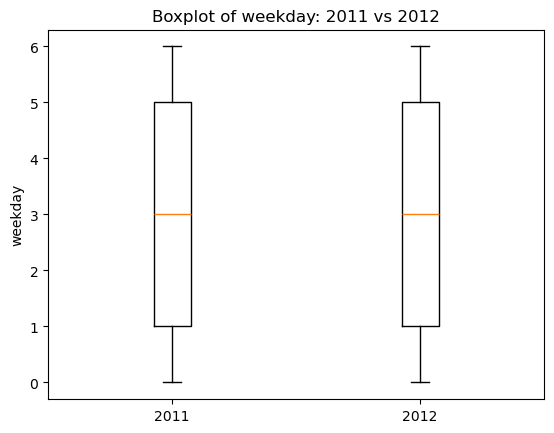

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


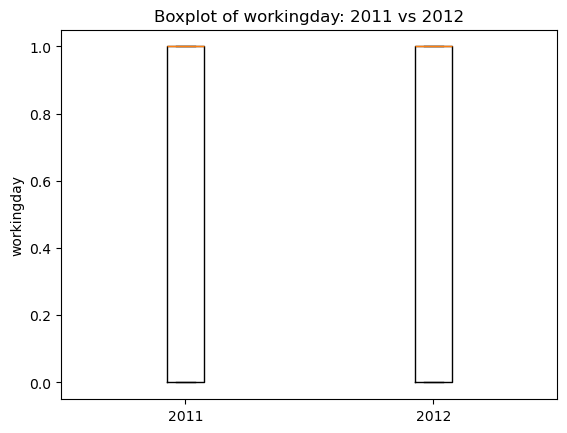

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


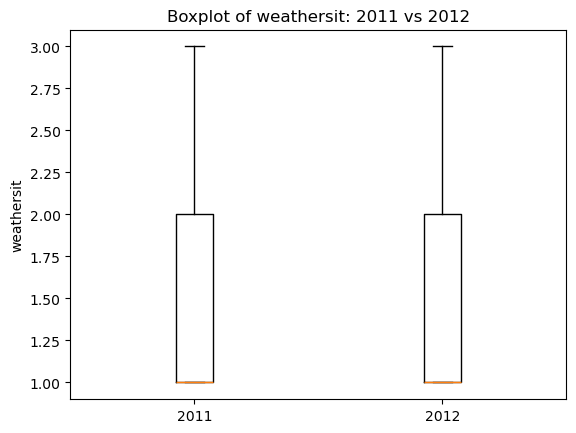

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


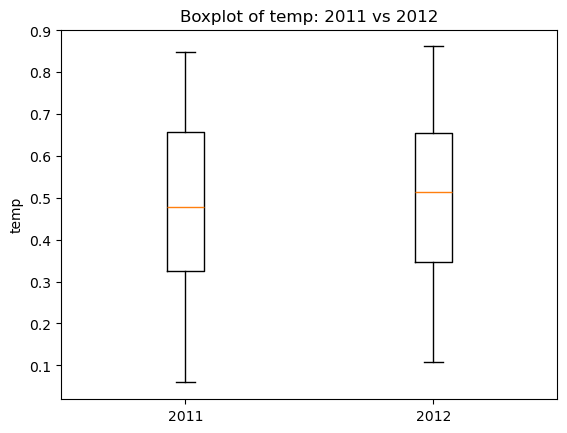

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


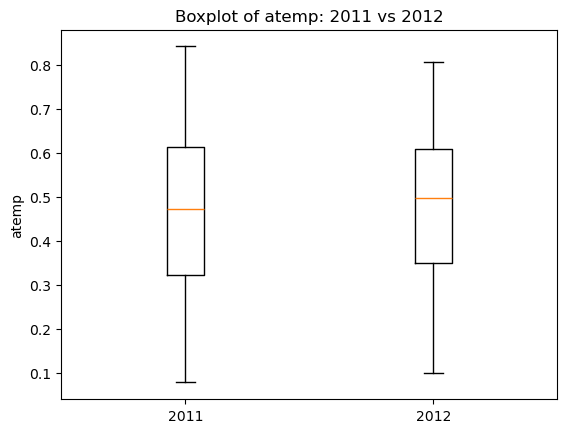

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


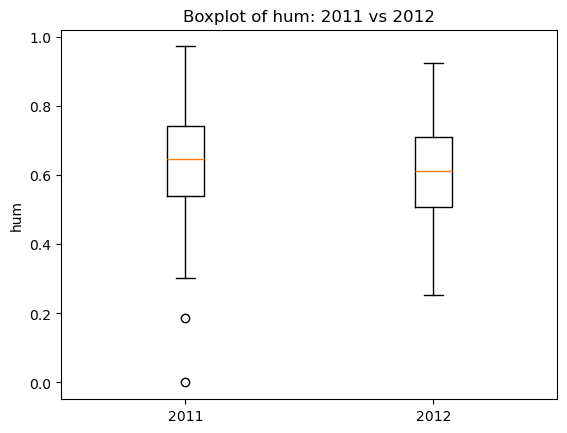

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


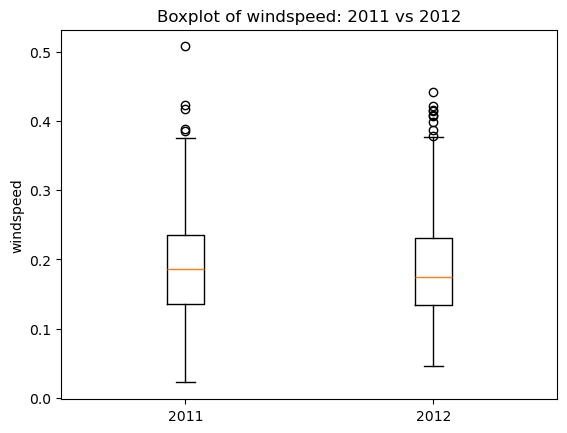

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


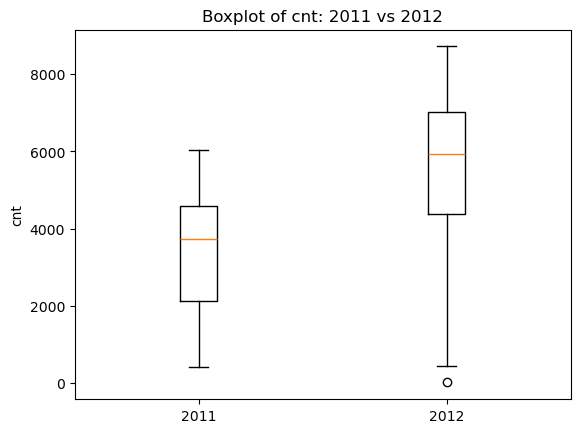

C:\Users\Admin\AppData\Local\Temp\ipykernel_6332\270582674.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])


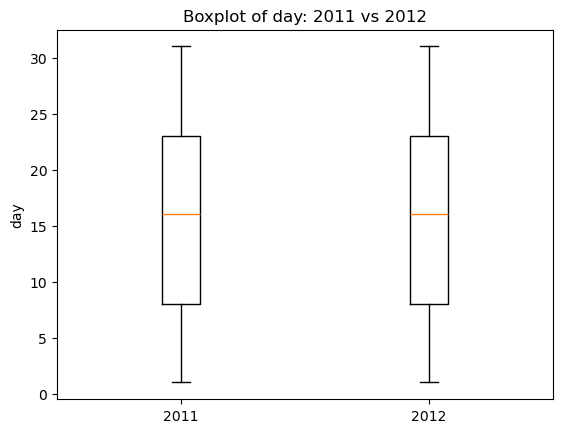

In [111]:
# Plot boxplots for comparisons of features
for col in num_cols:
    plt.figure()
    plt.boxplot([data_2011[col], data_2012[col]], labels=["2011", "2012"])
    plt.title(f"Boxplot of {col}: 2011 vs 2012")
    plt.ylabel(col)
    plt.show()


#### Most significant change for cnt column between 2011 and 2022, median value increased by around 2000, values between 25th and 75th percentiles are also greater in general

In [109]:
# Create dataframes showing mean and std for all columns for both years.
num_cols = data_2011.select_dtypes(include='number').columns
stats_2011 = data_2011[num_cols].agg(['mean', 'std'])
stats_2012 = data_2012[num_cols].agg(['mean', 'std'])
# Show mean and std of columns for 2011
stats_2011

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
mean,2.498630,6.526027,0.027397,3.008219,0.684932,1.421918,0.486665,0.466835,0.643665,0.191403,3405.761644,15.720548
std,1.110946,3.452584,0.163462,2.006155,0.465181,0.571831,0.189596,0.168836,0.148744,0.076890,1378.753666,8.808321


In [110]:
# Show mean and std of columns for 2012
stats_2012

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
mean,2.494536,6.513661,0.030055,2.986339,0.683060,1.368852,0.504081,0.481852,0.612166,0.189572,5599.934426,15.756831
std,1.112185,3.455958,0.170971,2.006108,0.465921,0.516057,0.176112,0.156756,0.134206,0.078194,1788.667868,8.823592


#### Slight decrease in average humidity (0.644 vs 0.612)
#### Large increase in average cnt (3406 vs 5600)
#### Std also affected by increase in values, increasing moderately (1379 vs 1789)

In [119]:
data_2012

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
0,1,1,0,0,0,1,0.370000,0.375621,0.692500,0.192167,2294,1
1,1,1,1,1,0,1,0.273043,0.252304,0.381304,0.329665,1951,2
2,1,1,0,2,1,1,0.150000,0.126275,0.441250,0.365671,2236,3
3,1,1,0,3,1,2,0.107500,0.119337,0.414583,0.184700,2368,4
4,1,1,0,4,1,1,0.265833,0.278412,0.524167,0.129987,3272,5
...,...,...,...,...,...,...,...,...,...,...,...,...
361,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,2114,27
362,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,3095,28
363,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1341,29
364,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,1796,30


array([[<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'mnth'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'weekday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weathersit'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'hum'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'cnt'}>, <Axes: title={'center': 'day'}>]],
      dtype=object)

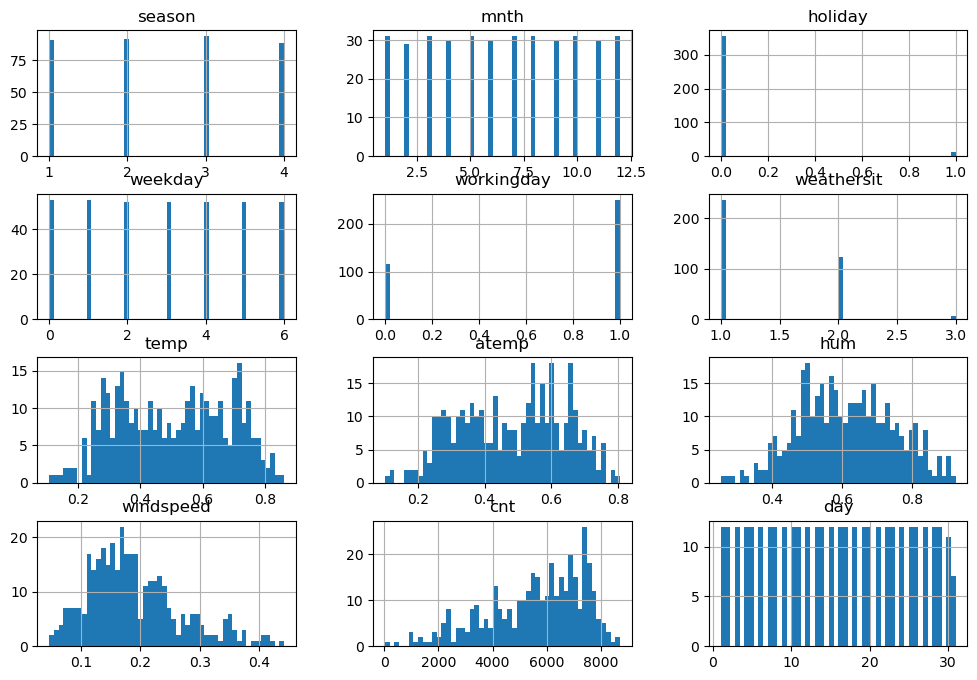

In [125]:
# View distribution of the dataset (check for outliers)
data_2012.hist(
    column=data_2012.columns,
    bins=50,
    figsize=(12, 8)
)

In [122]:
data_2012.isnull().sum()

season        0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
day           0
dtype: int64

In [128]:
# Perform train test split
x_train_2012, x_test_2012, y_train_2012, y_test_2012 = train_test_split(
    data_2012.drop(columns=['cnt']),
    data_2012['cnt'],
    test_size=0.2, random_state=611
)

In [130]:
# Fit encoder and transform training data
x_train_2012_enc = ohe.fit_transform(x_train_2012[["mnth", "season", "weekday", "weathersit","day"]])
# Make numpy array back into dataframe
x_train_2012_enc = pd.DataFrame(
    x_train_2012_enc, 
    columns=ohe.get_feature_names_out(["mnth", "season", "weekday", "weathersit","day"]), # Non-encoded columns not included 
    index=x_train_2012.index # Match index with pre-encoded data
)
# Concatenate the non-encoded columns using index
x_train_2012_enc = pd.concat([x_train_2012[["holiday","workingday","temp","atemp","hum","windspeed"]], x_train_2012_enc], axis=1)

# Transform test data
x_test_2012_enc = ohe.transform(x_test_2012[["mnth", "season", "weekday", "weathersit","day"]])
x_test_2012_enc = pd.DataFrame(
    x_test_2012_enc, 
    columns=ohe.get_feature_names_out(["mnth", "season", "weekday", "weathersit","day"]), # Non-encoded columns not included 
    index=x_test_2012.index # Match index with pre-encoded data
)
# Concatenate the non-encoded columns using index
x_test_2012_enc = pd.concat([x_test_2012[["holiday","workingday","temp","atemp","hum","windspeed"]], x_test_2012_enc], axis=1)


In [131]:
# Evaluate the optimized random forest model
test_pred_2012 = rf.predict(x_test_2012_enc)
print("Test R2 value after encoding:", r2_score(y_test_2012, test_pred_2012))
print("Test MAE value after encoding:", mean_absolute_error(y_test_2012, test_pred_2012))
print("Test RMSE value after encoding:", np.sqrt(mean_squared_error(y_test_2012, test_pred_2012)))

Test R2 value after encoding: -0.5045670454055784
Test MAE value after encoding: 2061.4629729729736
Test RMSE value after encoding: 2236.2175729508467


#### Significant decrease in performance across R2, MAE and RMSE.


#### The drifted feature that most likely contributed to the degradation is the target (cnt) column

#### From the negative R2, model performs worse than mean predicting model. 
#### MAE and RMSE experienced a significant increase 407 and 529 to 2061 and 2236

#### Predictions were, on average, 2061 off

### Recommended action: Retrain the model using day_2012.csv data

Significant target distribution shift (mean increased by 2200)

Increased demand volatility (std increased by 400)

These changes indicate concept drift, the relationships learned by the model no longer hold true and are inaccurate.

## Save the dataset used for evaluation

In [158]:
# Concatenate the input and target columns
test_data = pd.concat([x_test_enc, y_test], axis=1)

In [159]:
# Write the dataframe to a csv file saved in same folder as this notebook
test_data.to_csv("test_data.csv", index=False)